In [238]:
import os
import importlib
import prediction_age
importlib.reload(prediction_age)

from prediction_age import *

import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



## Data

In [13]:
path_data_france_age = os.path.join('..', 'data_france', 'all_age.csv')
path_data_france_all = os.path.join('..', 'data_france', 'all.csv')

data_france_age = pd.read_csv(path_data_france_age)
data_france_all = pd.read_csv(path_data_france_all)


Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.


In [14]:
data_france_age_sample = data_france_age.sample(frac=.2)
data_france_all_sample = data_france_all.sample(frac=.2)

## Hyperparameters

In [204]:
# increases computation time 10x compared to defaults
xgb_params_optimal = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

## Preprocessing

## Experiments

In [15]:
# predictor = AgePredictor(
#     model=LinearRegression(),
#     df=data_france_age,
#     test_training_split=split_by_region,
#     preprocessing_stages=[remove_other_attributes]
# )
# predictor.evaluate_regression()

In [16]:
# predictor = AgePredictor(
#     model=RandomForestRegressor(),
#     df=data_france_age_sample,
#     test_training_split=split_80_20,
#     preprocessing_stages=[remove_other_attributes]
# )
# predictor.evaluate_regression()

MAE: 45.68256423177209 y
RMSE: 65.18922982269473 y
R2: 0.2833212271400162


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


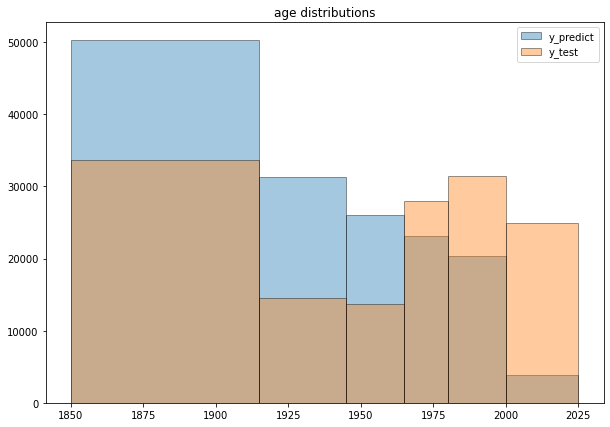

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

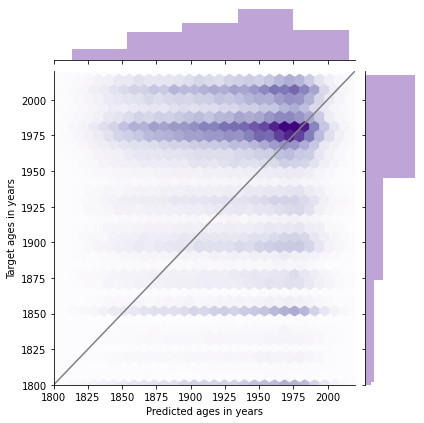

In [17]:
predictor_region = AgePredictor(
    model=xgboost.XGBRegressor(),
    df=data_france_age,
    test_training_split=split_by_region,
    preprocessing_stages=[remove_other_attributes]
)
predictor_region.evaluate_regression()

MAE: 16.25758751293071 y
RMSE: 21.193466353705308 y
R2: 0.38026626373997086


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


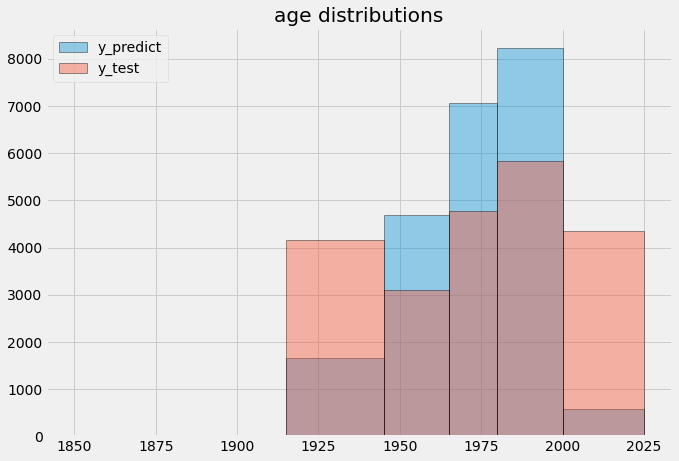

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

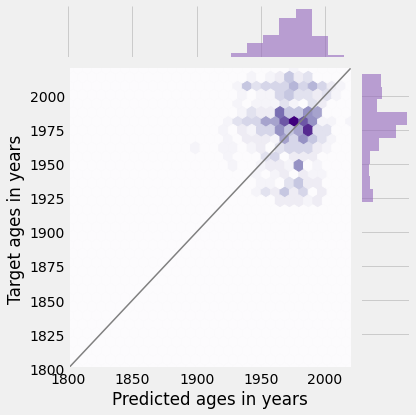

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


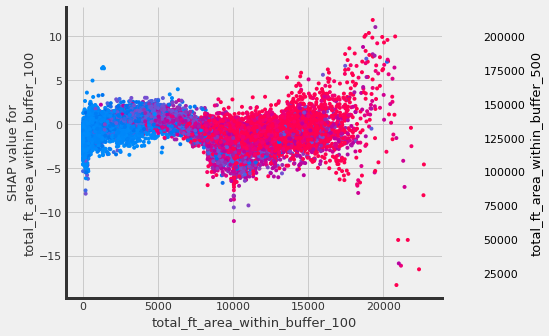

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


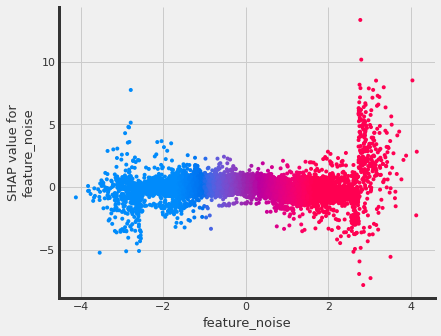

In [239]:
predictor_test = AgePredictor(
    model=xgboost.XGBRegressor(),
    df=data_france_age_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers, remove_other_attributes, add_noise_feature]
)
predictor_test.evaluate_regression()
predictor_test.feature_dependence_plot("total_ft_area_within_buffer_100", "total_ft_area_within_buffer_500")
predictor_test.feature_dependence_plot("feature_noise", "feature_noise")


MAE: 37.140084266253965 y
RMSE: 55.09031912184788 y
R2: 0.3959450932885612


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


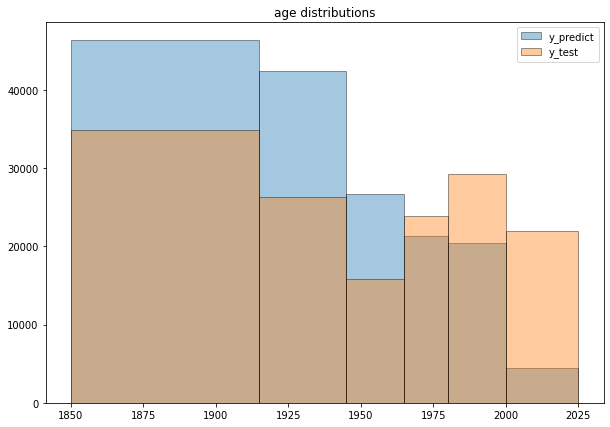

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

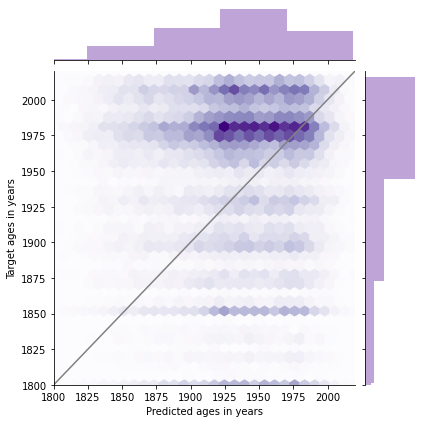

In [18]:
predictor = AgePredictor(
    model=xgboost.XGBRegressor(),
    df=data_france_age,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_other_attributes]
)
predictor.evaluate_regression()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


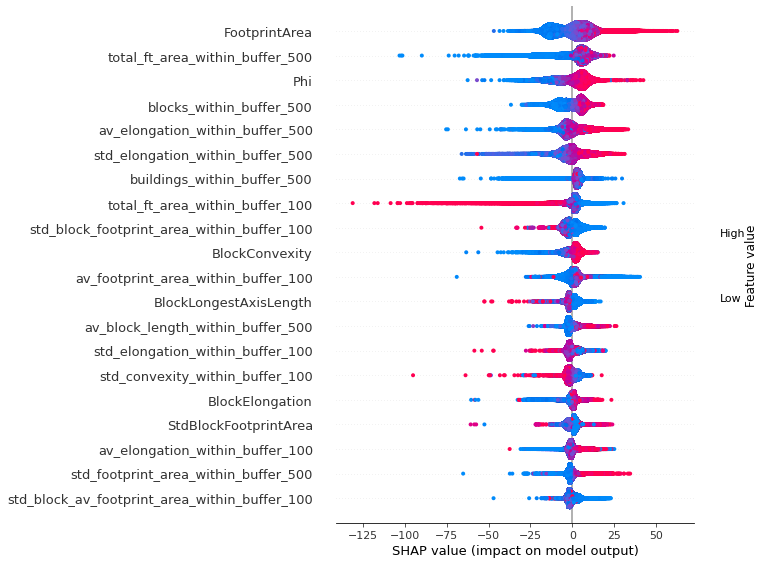

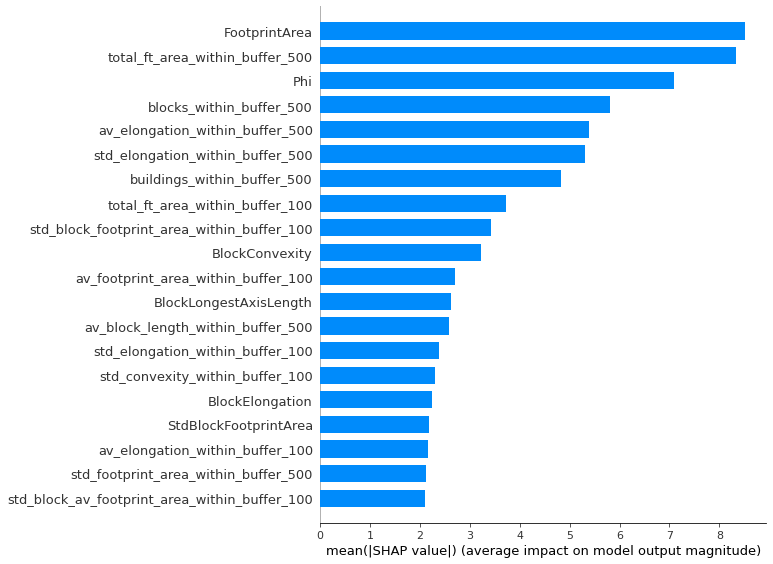

In [19]:
predictor.SHAP_analysis()

In [ ]:
predictor.neighborhood_feature_importance()
predictor.feature_selection()

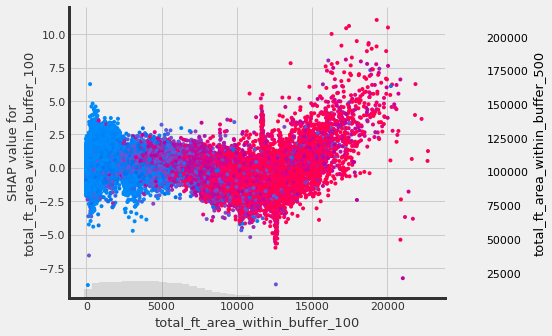

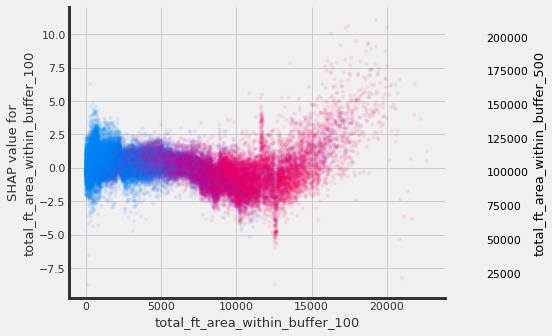

In [227]:
# https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html
# https://slundberg.github.io/shap/notebooks/plots/decision_plot.html
# shap.plots.scatter(ex[:,"feature_noise"], color=ex[:,"feature_noise"])
predictor_test.feature_dependence_plot("total_ft_area_within_buffer_100", "total_ft_area_within_buffer_500", transparency=0.1)

MAE: 36.38159455870863 y
RMSE: 54.01073084655253 y
R2: 0.41594394300315585


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


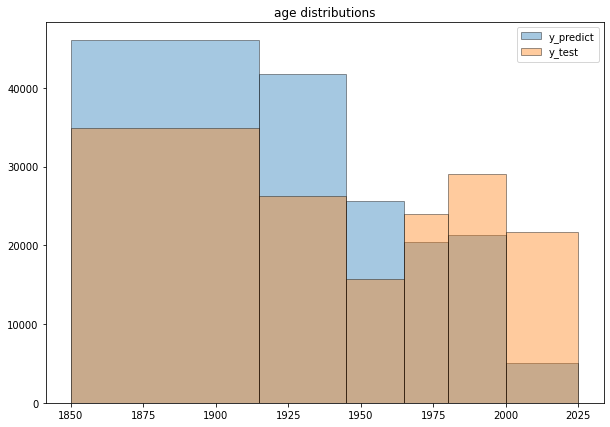

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

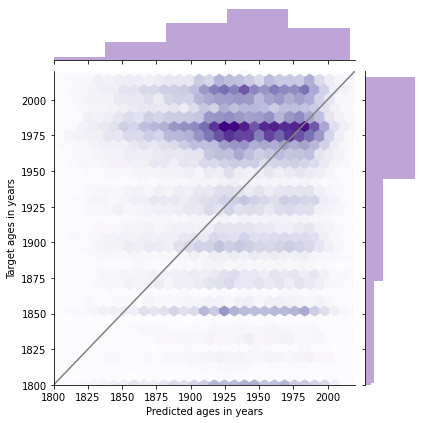

In [20]:
predictor_all_attributes = AgePredictor(
    model=xgboost.XGBRegressor(),
    df=data_france_age,
    test_training_split=split_80_20,
    preprocessing_stages=[keep_other_attributes]
)
predictor_all_attributes.evaluate_regression()

In [21]:
# predictor = AgePredictor(
#     model=xgboost.XGBRegressor(),
#     df=data_france_age_sample,
#     test_training_split=split_80_20,
#     preprocessing_stages=[remove_other_attributes],
#     hyperparameter_tuning=True
# )
# predictor.evaluate_regression()

              precision    recall  f1-score   support

           0       0.50      0.65      0.57     28491
           1       0.53      0.60      0.56     26227
           2       0.54      0.34      0.42     16799
           3       0.51      0.50      0.50     25275
           4       0.53      0.51      0.52     27847
           5       0.54      0.42      0.47     20615

    accuracy                           0.52    145254
   macro avg       0.52      0.50      0.51    145254
weighted avg       0.52      0.52      0.51    145254



`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


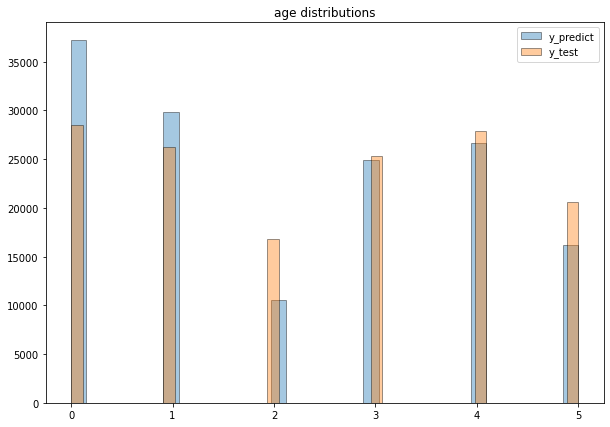

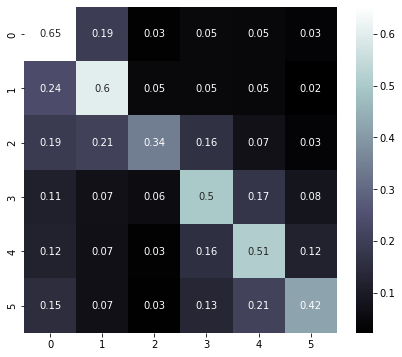

In [22]:
model = xgboost.XGBClassifier(objective='multi:softmax', num_class=6, use_label_encoder=False, eval_metric=["merror", "mlogloss"])
classifier = AgePredictor(
    model=model,
    df=data_france_age,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers, remove_other_attributes, categorize_age]
)
classifier.evaluate_classification()

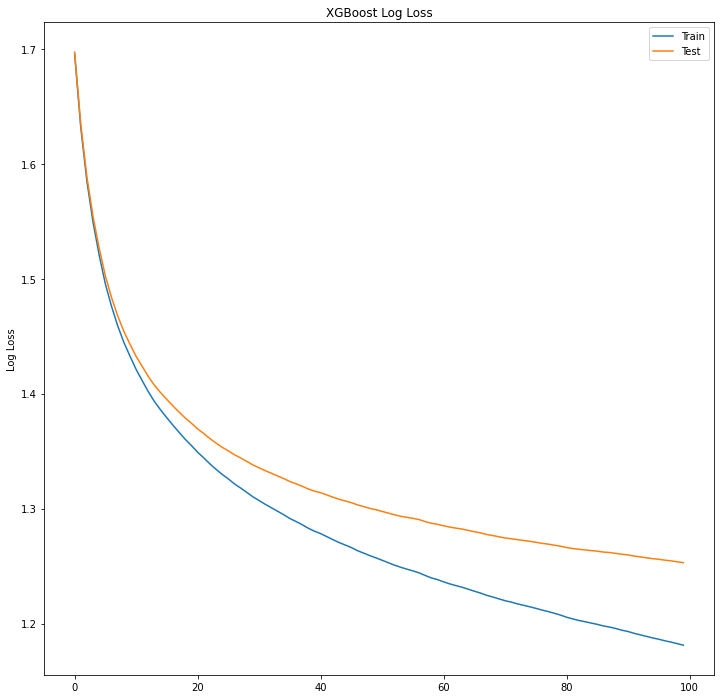

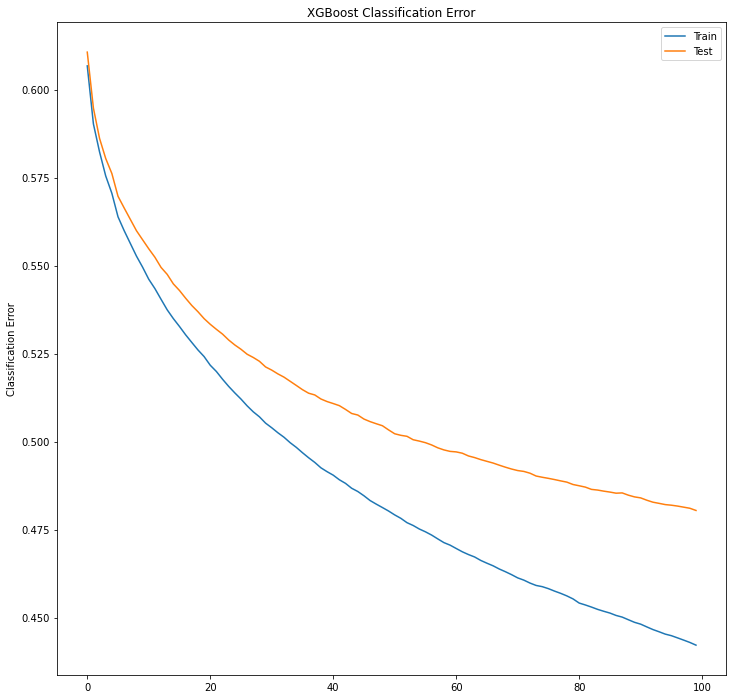

In [23]:
plot_log_loss(classifier.model)
plot_classification_error(classifier.model)

In [ ]:
classifier.SHAP_analysis()

In [240]:
classifier.neighborhood_feature_importance()
classifier.feature_selection()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## Hyperparameter Tuning

In [199]:
grid_search_results = os.path.join('..', 'notebooks', 'hyperparameter-tuning-results.csv')

df_grid_search = pd.read_csv(grid_search_results, sep='\t')
df_grid_search.sort_values(by=['Accuracy'], ascending=False).head(10)

,Unnamed: 0,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,Accuracy
71,71,0.7,0.05,10,1000,1.0,-53.422715
70,70,0.7,0.05,10,1000,0.7,-53.522213
17,17,0.3,0.05,10,1000,1.0,-53.552385
16,16,0.3,0.05,10,1000,0.7,-53.685446
69,69,0.7,0.05,10,500,1.0,-53.737943
89,89,0.7,0.10,10,1000,1.0,-53.793918
15,15,0.3,0.05,10,500,1.0,-53.841906
68,68,0.7,0.05,10,500,0.7,-53.853294
87,87,0.7,0.10,10,500,1.0,-53.885752
35,35,0.3,0.10,10,1000,1.0,-53.908108


In [ ]:
regr = LinearRegression()
y = df_grid_search[['Accuracy']]
X = df_grid_search.drop(columns=['Accuracy'])
regr.fit(X, y)
# np.multiply(regr.coef_[0][:-1],[3.5,0.1,500,0.3,0.3])
pd.DataFrame({'feature': df_grid_search.columns[1:],'reg coef': regr.coef_[0]})